In [169]:
import datetime
import feature_engg as engg
import feature_util as utl
import json
import math
import numpy as np
import os
import pandas as pd
from sklearn import metrics
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import subprocess

In [2]:
# cities
df_cities = pd.read_csv('../data/world_cities.txt', sep=",")
df_cities = df_cities[['country', 'city', 'lat', 'lon']]

# events
df_events = utl.get_df('../data/events.json', encoding='utf-8')

# groups
df_groups = utl.get_df('../data/groups.json', encoding='utf-8')

# users
df_users = utl.get_df('../data/users.json', encoding='utf-8')
df_users['city'] = df_users.city.str.lower()
df_users = df_users.merge(df_cities, on=['country', 'city'])
df_users.columns = [str(col) + '_u' for col in df_users.columns]

# venues
df_venues = utl.get_df('../data/venues.json', encoding='utf-8')
df_venues['city'] = df_venues.city.str.lower()
df_venues.columns = [str(col) + '_v' for col in df_venues.columns]


<type 'list'>
<type 'list'>
<type 'list'>
<type 'list'>


C:\Users\310195644\AppData\Local\Continuum\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_events = df_events.assign(event_id=[i+1 for i in xrange(len(df_events))])
df_events_flat = utl.flatten_list(df_events, 'rsvps', reset_index=True)
df_events_flat = utl.flatten_dict(df_events_flat, 'rsvps')
df_events_flat['label'] = df_events_flat.response.apply(lambda x: engg.label_attendance(x))
df_events_flat['total_att'] = df_events_flat.label + df_events_flat.guests

In [ ]:
# n_events_peruser = df_events_flat.groupby(['user_id']).agg({'label': 'sum'}).reset_index()
# print 'Total attendance: \n', df_events_flat.total_att.describe()
# print '\nResponse summary: \n', df_events_flat.response.value_counts()
# print '\nGuest count summary: \n', df_events_flat.guests.describe()
# print 'Number of events attended per user: \n', n_events_peruser.label.describe()
# print '\nStatus of events:\n', df_events_flat.status.value_counts()

In [8]:
df_events_flat = df_events_flat.merge(df_venues, left_on='venue_id', right_on='venue_id_v', how='left')
df_events_flat = df_events_flat.merge(df_users, left_on='user_id', right_on='user_id_u', how='left')
del df_events_flat['venue_id_v'], df_events_flat['user_id_u']

In [88]:
df_events_flat['uv_sim'] = df_events_flat.apply(lambda row: lat_lon_similarity(row['lat_v'], row['lon_v'], 
                                                                               row['lat_u'], row['lon_u']), axis=1)
df_events_flat = df_events_flat[df_events_flat.time.notnull()]
df_events_flat['datetime'] = pd.to_datetime((df_events_flat['time']/1000).astype(int), unit='s')
df_events_flat['event_hour'] = df_events_flat.datetime.dt.hour
df_events_flat['event_day_of_week'] = df_events_flat.datetime.dt.dayofweek
df_events_flat['reg_time'] = (df_events_flat.time - df_events_flat.created) / 3600000

In [120]:
df_agg = df_events_flat.groupby(['event_id', 'event_hour', 'event_day_of_week', 'reg_time']) \
                       .agg({'uv_sim' : 'mean', 'total_att' : 'sum'}).reset_index()
df_agg['event_hour_1'] = df_agg.event_hour.apply(lambda x: event_hour_transform(x))
df_agg['day_1'] = np.where(df_agg.event_day_of_week==1, 1, 0)
df_agg['day_2'] = np.where(df_agg.event_day_of_week==2, 1, 0)
df_agg['day_3'] = np.where(df_agg.event_day_of_week==3, 1, 0)
df_agg['day_4'] = np.where(df_agg.event_day_of_week==4, 1, 0)
df_agg['day_5'] = np.where(df_agg.event_day_of_week==5, 1, 0)
df_agg['day_6'] = np.where(df_agg.event_day_of_week==6, 1, 0)
df_agg = df_agg.dropna(axis=0, how='any')
df_data = df_agg.drop(['event_id', 'event_hour', 'event_day_of_week'], axis=1)

In [147]:
X.corr(method='pearson')

,reg_time,uv_sim,event_hour_1,day_1,day_2,day_3,day_4,day_5,day_6
reg_time,1.000000,0.016936,0.051495,-0.068668,0.103961,0.055521,-0.055066,-0.049587,-0.035338
uv_sim,0.016936,1.000000,0.094458,-0.048447,0.002194,-0.049794,0.007783,0.150462,0.048417
event_hour_1,0.051495,0.094458,1.000000,-0.154578,-0.076847,-0.062001,0.038706,0.449689,0.117892
day_1,-0.068668,-0.048447,-0.154578,1.000000,-0.285043,-0.278774,-0.162295,-0.147103,-0.069992
day_2,0.103961,0.002194,-0.076847,-0.285043,1.000000,-0.338215,-0.196900,-0.178469,-0.084916
day_3,0.055521,-0.049794,-0.062001,-0.278774,-0.338215,1.000000,-0.192569,-0.174543,-0.083048
day_4,-0.055066,0.007783,0.038706,-0.162295,-0.196900,-0.192569,1.000000,-0.101615,-0.048348
day_5,-0.049587,0.150462,0.449689,-0.147103,-0.178469,-0.174543,-0.101615,1.000000,-0.043823
day_6,-0.035338,0.048417,0.117892,-0.069992,-0.084916,-0.083048,-0.048348,-0.043823,1.000000


In [134]:
X = df_data.drop('total_att', axis=1)
Y = df_data.total_att
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [153]:
lm = LinearRegression()
lm.fit(X=X_train, y=y_train)
# scores = cross_val_score(lm, X_train, y_train, cv=5)
# predicted = cross_val_predict(lm, X_test, y_test, cv=5)
predicted = lm.predict(X=X_test)
metrics.r2_score(y_test, predicted) 

0.057243213418054495

In [143]:
df_result = pd.DataFrame({'target': y_test, 'predict': predicted})

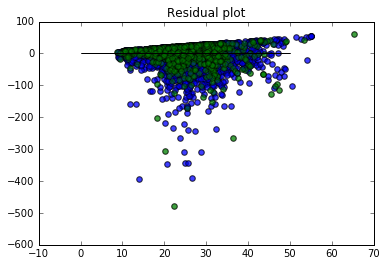

In [157]:
import matplotlib.pyplot as plt
plt.scatter(lm.predict(X_train), lm.predict(X_train)-y_train, c='b', s=30, alpha=0.5)
plt.scatter(lm.predict(X_test), lm.predict(X_test)-y_test, c='g', s=30, alpha=0.5)
plt.hlines(y=0, xmin=0, xmax=50)
plt.title('Residual plot')
plt.show()

In [192]:
clf = tree.DecisionTreeRegressor(max_depth=3)
clf = clf.fit(X_train, y_train)
predict = clf.predict(X_test)

In [193]:
predict

array([ 40.09580838,  13.81919452,  40.09580838, ...,  22.61370717,
        22.61370717,  22.61370717])

In [194]:
print "R2 is ", metrics.r2_score(y_test, predict)

R2 is  0.164879470619


In [195]:
def visualize_tree(clf, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        tree.export_graphviz(clf, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "./dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [196]:
features = X.columns

In [197]:
visualize_tree(clf, features)

In [198]:
with open("attend_reg.txt", "w") as f:
    f = tree.export_graphviz(clf, out_file=f, feature_names=features)